# Imports

In [1]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
from IPython.display import clear_output

# Dataset

In [0]:
languages = []
data = []

X = []
Y = []

with open('name2lang.txt','r') as f:
  for line in f:
    line = line.split(',')
    name = line[0].strip()
    lang = line[1].strip()
    if not lang in languages:
      languages.append(lang)
    X.append(name)
    Y.append(lang)
    data.append((name,lang))

In [0]:
n_languages = len(languages)

In [9]:
print(n_languages)
print(languages)
print(data[0:10])

18
['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']
[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


# Train-test split

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state=0, stratify=Y)

# Encoding names and languages

In [12]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(n_letters)
print(all_letters)

57
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [16]:
type(all_letters)

str

In [0]:
def name_rep(name):

  """
  Returns the stacked one-hot encoding of the input word.
  """
  rep = torch.zeros(len(name),1,n_letters) # Stacking
  for index, letter in enumerate(name):
    pos = all_letters.index(letter)
    rep[index][0][pos] = 1 # Marking
  return rep

In [24]:
name_rep("Shiv")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [0]:
def lang_rep(lang):
  rep = torch.zeros(n_languages,dtype=torch.long)
  pos = languages.index(lang)
  rep[pos] = 1
  return rep

In [18]:
lang_rep("Spanish")

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [80]:
lang_rep("Spanish").argmax().item()

2

# Basic visualisation

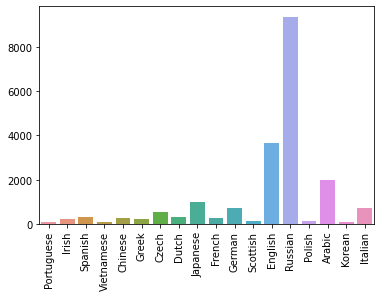

In [31]:
"""
This can be used to figure out the baseline accuracy i.e. if we were to sample input randomly and output randomly,
what accuracy would we achieve.
"""

count = {}
for l in languages:
  count[l] = 0

for d in data:
  count[d[1]]+=1

plt_ = sns.barplot(list(count.keys()),list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(),rotation=90)
plt.show()

# Basic net and testing inference

In [0]:
class RNN_net(nn.Module):

  def __init__(self,input_size, hidden_size, output_size):

    super(RNN_net, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size+hidden_size,hidden_size)
    self.i2o = nn.Linear(input_size+hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self,input_, hidden):
    combined = torch.cat((input_, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

  def infer(self,name):
    self.eval()
    name_ohe = name_rep(name)
    hidden = self.init_hidden()
    for i in range(name_ohe.shape[0]):
      output, hidden = self(name_ohe[i],hidden)
    
    return output

  def evaluate(self,n_points,k, X_, Y_):
    data_ = dataloader(n_points, X_, Y_)
    correct = 0

    for name, lang, name_ohe, lang_rep in data_:
      output = self.infer(name)

      #tuple returned by the top method and not as a property of output
      val, indices = output.topk(k)

      if lang_rep.argmax().item() in indices:
        correct+=1
      
    accuracy = correct/n_points
    return accuracy

  def train_net(self,opt, criterion, n_points):
    opt.zero_grad()
    total_loss = 0

    data_ = dataloader(n_points, X_train, Y_train)

    for name, lang, name_ohe, lang_rep in data_:
      hidden = self.init_hidden()
      for i in range(name_ohe.shape[0]):
        output, hidden = self(name_ohe[i],hidden)

      loss = criterion(output, lang_rep.argmax().reshape(-1))
    
      loss.backward(retain_graph = True)
      total_loss += loss

    opt.step()

    return total_loss/n_points

In [0]:
class RNN_net_2(nn.Module):

  def __init__(self,input_size, hidden_size_1,hidden_size_2, hidden_output_size,output_size):

    super(RNN_net_2, self).__init__()

    self.hidden_size_1 = hidden_size_1
    self.hidden_size_2 = hidden_size_2
    self.i2h = nn.Linear(input_size+hidden_size_1,hidden_size_1)
    self.i2a = nn.Linear(input_size+hidden_size_1,hidden_output_size)
    self.a2h = nn.Linear(hidden_output_size+hidden_size_2, hidden_size_2)
    self.a2o = nn.Linear(hidden_output_size+hidden_size_2, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self,input_, hidden1,hidden2):
    combined1 = torch.cat((input_, hidden1), 1)
    hidden1 = self.i2h(combined1)
    intermediate_output = self.i2a(combined1)

    combined2 = torch.cat((intermediate_output, hidden2),1)
    hidden2 = self.a2h(combined2)
    output = self.a2o(combined2)
    output = self.softmax(output)
    return output, hidden1, hidden2

  def init_hidden(self, hidden_number):
    if hidden_number == 1:
      return torch.zeros(1,self.hidden_size_1)
    else:
      return torch.zeros(1,self.hidden_size_2)
  
  def infer(self, name):
    self.eval()
    name_ohe = name_rep(name)
    hidden1 = self.init_hidden(1)
    hidden2 = self.init_hidden(2)

    for i in range(name_ohe.shape[0]):
      output, hidden1, hidden2 = self(name_ohe[i],hidden1, hidden2)

    return output

  def evaluate(self, n_points, k, X_, Y_):
    data_ = dataloader(n_points, X_, Y_)
    correct = 0

    for name, lang, name_ohe, lang_rep in data_:
      output = self.infer(name)

      #tuple returned by the top method and not as a property of output
      val, indices = output.topk(k)

      if lang_rep.argmax().item() in indices:
        correct+=1
      
    accuracy = correct/n_points
    return accuracy

  def train_net(self, opt, criterion, n_points):
    opt.zero_grad()
    total_loss = 0

    data_ = dataloader(n_points, X_train, Y_train)

    for name, lang, name_ohe, lang_rep in data_:
      hidden1 = self.init_hidden(1)
      hidden2 = self.init_hidden(2)
      for i in range(name_ohe.shape[0]):
        output, hidden1, hidden2 = self(name_ohe[i],hidden1, hidden2)

      loss = criterion(output, lang_rep.argmax().reshape(-1))
    
      loss.backward(retain_graph = True)
      total_loss += loss

    opt.step()

    return total_loss/n_points

In [0]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)

In [202]:
net.infer("Shiv")

tensor([[-2.9409, -2.8870, -2.8333, -2.8005, -2.9231, -2.9669, -2.8091, -2.8630,
         -2.8716, -2.8757, -2.7664, -2.8844, -2.9115, -2.9399, -2.9458, -2.9553,
         -2.9828, -2.9013]], grad_fn=<LogSoftmaxBackward>)

In [0]:
n_hidden1 = 256
n_hidden2 = 128
intermediate_output_size = 128

net2 = RNN_net_2(n_letters,n_hidden1, n_hidden2, intermediate_output_size, n_languages)

In [49]:
name_ohe = name_rep("Shiv")
name_ohe.shape[0]

4

In [54]:
output = net.infer("Shiv")
index = torch.argmax(output)
print(index,output)
print(languages[index])

tensor(7) tensor([[-2.9906, -2.8811, -2.8338, -2.9741, -2.9198, -2.9601, -2.8817, -2.7732,
         -2.8633, -2.9193, -2.8828, -2.9054, -2.8129, -2.8683, -2.8464, -2.8596,
         -2.8704, -3.0174]], grad_fn=<LogSoftmaxBackward>)
Dutch


In [159]:
output2 = infer2(net2, "Shiv")
index2 = torch.argmax(output2)
print(index2,output2)
print(languages[index2])

tensor(14) tensor([[-2.9642, -2.8547, -2.8590, -2.9540, -2.8544, -2.8982, -2.9047, -2.8694,
         -2.8751, -2.9128, -2.8699, -2.8696, -2.9465, -2.8977, -2.8013, -2.8290,
         -2.9240, -2.9605]], grad_fn=<LogSoftmaxBackward>)
Polish


# Evaluate model

In [0]:
def dataloader(n_points, X_, Y_):
  to_ret = []
  for i in range(n_points):
    index_ = np.random.randint(len(X_))
    name,lang = X_[index_],Y_[index_]
    to_ret.append((name,lang, name_rep(name),lang_rep(lang)))
  return to_ret

In [56]:
dataloader(2, X_train, Y_train)

[('Kellems',
  'English',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [77]:
n_languages

18

In [74]:
v, i = infer(net,"Shiv").topk(3)
i

tensor([[ 7, 12,  2]])

In [194]:
net.evaluate(1000,3,X_test, Y_test)

0.184

In [163]:
net2.evaluate(1000, 3, X_test, Y_test)

0.066

# Training

In [203]:
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(),lr = 0.01, momentum = 0.9)
net.train_net(opt, criterion, 200)
net.evaluate(1000, 1, X_test, Y_test)

0.443

In [209]:
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(),lr = 0.01, momentum = 0.9)
net2.train_net(opt, criterion, 200)
net2.evaluate(1000, 1, X_test, Y_test)

0.019

# Full training setup

In [0]:
def train_setup(net, lr=0.01, n_batches=100, batch_size=10, momentum=0.9, display_freq=5):

  criterion = nn.NLLLoss()
  opt = optim.SGD(net.parameters(),lr=lr,momentum=momentum)

  loss_arr = np.zeros(n_batches+1)

  for i in range(n_batches):
    loss_arr[i+1] = (loss_arr[i]*i + net.train_net(opt, criterion, batch_size))/(i+1)

    if i%display_freq==0:
      clear_output(wait=True)
      print("Iteration:",i,"Top-1",net.evaluate(len(X_test),1,X_test, Y_test),"Top-2",net.evaluate(len(X_test),2,X_test, Y_test))
      plt.figure()
      plt.plot(loss_arr[1:i],'-*')
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.show()
      print("\n\n")

Iteration: 95 Top-1 0.6526184538653367 Top-2 0.7688279301745636


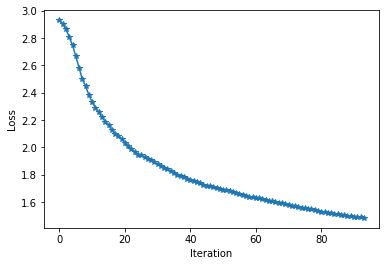

In [205]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.0005, n_batches=100, batch_size=256)

Iteration: 95 Top-1 0.6837905236907731 Top-2 0.7837905236907731


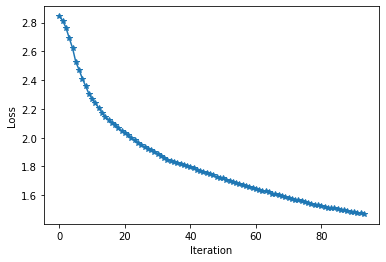

In [212]:
train_setup(net2, lr=0.0005, n_batches=100, batch_size=256)

In [223]:
languages[net2.infer("").argmax().item()]

'English'

# LSTM